# Bike Accident Mapper 

In [60]:
#import libraries
import pandas as pd
import numpy as np
import geopy
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Bike_Accidents")

In [14]:
#load data
df = pd.read_excel('bike_accidents.xlsx', encoding='WINDOWS-1255')
df.head()

,סוג פגיעה,תאריך,גיל,אופניים רגילים או חשמליים,מיקום,עיר או כביש,לינק,כתובת מדוייק
0,קשה,2018-07-16 00:00:00,NaN,חשמליים,צומת בית דגן,ראשון לציון,http://www.kolhazman.co.il/322936,NaN
1,הרוג,2018-07-08 00:00:00,8.0,אופניים,סלעית,סלעית,"https://www.ynet.co.il/articles/0,7340,L-53065...",NaN
2,בינוני,2018-07-16 00:00:00,NaN,אופניים,הנביאים,חיפה,https://haipo.co.il/item/101660,NaN
3,בינוני,2018-07-16 00:00:00,16.0,חשמליים,צומת קרית חיים,NaN,https://haipo.co.il/item/101658,כביש 4
4,בינוני,2018-07-13 00:00:00,8.0,אופניים,חניתה,חיפה,https://haipo.co.il/item/101476,חניתה פינת טרומפלדור


In [ ]:
df.iloc[:,3]

In [165]:
#Rebuild Table with english variables + new Variables
data = {"Date" : df['תאריך'],
       "Age" : df['גיל'],
       "Injury Type" : df['סוג פגיעה'],
       "Vehicle Type" : df.iloc[:,3],
        "Street" : df.iloc[:,5],
        "Detailed Street" : df.iloc[:,7],
        "City" : df.iloc[:,4],
        "Address" : "",
        "Link" : df.iloc[:,6],
        "location" : "",
        "lat" : "",
        "long" : ""
      }
df2 = pd.DataFrame.from_dict(data)
df2['Age Range'] = pd.cut(df2.Age, [0,10,20,30,40,50,60,100], 
                          labels=['Under 10', '11 to 20', '21 to 30','30 to 40',
                                  '40 to 50','50 to 60','Over 60'])
                          


In [178]:
## Add category Unknown and replace null with unknown
#df2['Age Range'].cat.add_categories('Unknown')
df2['Age Range'].cat.categories
df2['Age Range'] = df2['Age Range'].fillna("Unknown")

In [179]:
df2.head()

,Date,Age,Injury Type,Vehicle Type,Street,Detailed Street,City,Address,Link,location,lat,long,Age Range
0,2018-07-16 00:00:00,NaN,קשה,חשמליים,ראשון לציון,NaN,צומת בית דגן,,http://www.kolhazman.co.il/322936,,,,Unknown
1,2018-07-08 00:00:00,8.0,הרוג,אופניים,סלעית,NaN,סלעית,,"https://www.ynet.co.il/articles/0,7340,L-53065...",,,,Under 10
2,2018-07-16 00:00:00,NaN,בינוני,אופניים,חיפה,NaN,הנביאים,,https://haipo.co.il/item/101660,,,,Unknown
3,2018-07-16 00:00:00,16.0,בינוני,חשמליים,NaN,כביש 4,צומת קרית חיים,,https://haipo.co.il/item/101658,,,,11 to 20
4,2018-07-13 00:00:00,8.0,בינוני,אופניים,חיפה,חניתה פינת טרומפלדור,חניתה,,https://haipo.co.il/item/101476,,,,Under 10


In [180]:
## fill Street/City NaN with blank
df2['Street'] = df2['Street'].fillna("")
df2['City'] = df2['City'].fillna("")

df2['Address'] = df2['Street'] + ", " + df2['City']


In [181]:
df2['Address'].head()

0    ראשון לציון, צומת בית דגן
1                 סלעית, סלעית
2                חיפה, הנביאים
3             , צומת קרית חיים
4                  חיפה, חניתה
Name: Address, dtype: object

In [53]:
#First attempt - fails on timeout
#df2['location'] = df['Address'].apply(geolocator.geocode)


In [182]:
#create empty lists for location, lat and long
locations = []
latitudes = []
longitudes = []

#iterate between each row in df2 and geocode location based on 'Address'
for index, row in df2.iterrows():
    address = row['Address']
    #print(address)
    location = geolocator.geocode(address, timeout=10)
    locations.append(location)
    print(location)
    #add long/lat
    if(location != None):
        #if location exists
        print(location.latitude,location.longitude)
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
    else:
        #if no location set default lat,long - 32,34
        print(32,34)
        latitudes.append(32)
        longitudes.append(34)
        
    
#print(locations)
    
    


צומת בית דגן, השבעה, נחלת יהודה, ראשון לציון, מחוז המרכז, NO, ישראל
32.002455 34.820515
סלעית/יסעור, סלעית, ערד, מחוז הדרום, NO, ישראל
31.266409 35.21135
הנביאים, חיפה, הדר הכרמל, חיפה, מחוז חיפה, NO, ישראל
32.8129956 34.995452
צומת קרית חיים, שדרות ההסתדרות, קרית חיים, קריית חיים מזרחית, חיפה, מחוז חיפה, NO, ישראל
32.817155 35.076678
חניתה, חיפה, נוה שאנן, חיפה, מחוז חיפה, NO, ישראל
32.7862429 35.0174697
None
32 34
האלוף עוזי נרקיס, קרית מנחם בגין, שועפט, ירושלים, מחוז ירושלים, NO
31.8209146 35.2335602
אליהו בן חור, אם המושבות החדשה, פתח תקווה, מחוז המרכז, NO, ישראל
32.1075075 34.8765451
ז'בוטינסקי, גבעת שמואל, רמת גן, מחוז תל אביב, NO, ישראל
32.0718863 34.8509527
קרית אונו, 23, לוי אשכול, קריית אונו, מחוז תל אביב, NO, ישראל
32.0637716 34.8616367
גניחובסקי, פרדס כץ, בני ברק, מחוז תל אביב, NO, ישראל
32.0990657 34.841524
None
32 34
מעבר בני ברית העצמאות, רובע ה', אשדוד, מחוז הדרום, NO, ישראל
31.7911515 34.6489388388525
חיים עוזר, מרכז העיר, פתח תקווה, מחוז המרכז, NO, ישראל
32.0853546 34

In [183]:
#update table with geocoded location, lat and long
df2['location'] = locations
df2['lat'] = latitudes
df2['long'] = longitudes

In [184]:
df2.head()

,Date,Age,Injury Type,Vehicle Type,Street,Detailed Street,City,Address,Link,location,lat,long,Age Range
0,2018-07-16 00:00:00,NaN,קשה,חשמליים,ראשון לציון,NaN,צומת בית דגן,"ראשון לציון, צומת בית דגן",http://www.kolhazman.co.il/322936,"(צומת בית דגן, השבעה, נחלת יהודה, ראשון לציון,...",32.002455,34.820515,Unknown
1,2018-07-08 00:00:00,8.0,הרוג,אופניים,סלעית,NaN,סלעית,"סלעית, סלעית","https://www.ynet.co.il/articles/0,7340,L-53065...","(סלעית/יסעור, סלעית, ערד, מחוז הדרום, NO, ישרא...",31.266409,35.211350,Under 10
2,2018-07-16 00:00:00,NaN,בינוני,אופניים,חיפה,NaN,הנביאים,"חיפה, הנביאים",https://haipo.co.il/item/101660,"(הנביאים, חיפה, הדר הכרמל, חיפה, מחוז חיפה, NO...",32.812996,34.995452,Unknown
3,2018-07-16 00:00:00,16.0,בינוני,חשמליים,,כביש 4,צומת קרית חיים,", צומת קרית חיים",https://haipo.co.il/item/101658,"(צומת קרית חיים, שדרות ההסתדרות, קרית חיים, קר...",32.817155,35.076678,11 to 20
4,2018-07-13 00:00:00,8.0,בינוני,אופניים,חיפה,חניתה פינת טרומפלדור,חניתה,"חיפה, חניתה",https://haipo.co.il/item/101476,"(חניתה, חיפה, נוה שאנן, חיפה, מחוז חיפה, NO, י...",32.786243,35.017470,Under 10


In [193]:
df2_eng = df2

In [196]:
df2_eng = df2_eng.replace({'Injury Type' : {'הרוג':'Death', 'קל':'Minor', 'בינוני':'Moderate', 'בינוני עד קשה':'Serious', 'בינוני-קשה':'Serious','קשה':'Severe','אנוש':'Critical'}})

In [197]:
accidentByAgeRange = accidentByAge.groupby('Age Range').sum()
accidentByAgeRange

,Age,count
Age Range,,
"(0.0, 10.0]",8.0,4
"(10.0, 20.0]",136.0,24
"(20.0, 30.0]",129.0,8
"(30.0, 40.0]",106.0,4
"(40.0, 50.0]",92.0,4
"(50.0, inf]",232.0,4


In [121]:
accidentByAge.head()

,Age,count,Age Range
0,8.0,4,NaN
1,11.0,1,"(10, 20]"
2,12.0,1,"(10, 20]"
3,13.0,2,"(10, 20]"
4,14.0,3,"(10, 20]"


In [218]:
accidentByAge = df2.groupby('Age').size().reset_index(name='count')
accidentByAge['count'].sum()

48

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B54453D470>]],
      dtype=object)

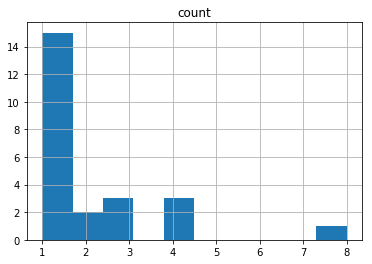

In [227]:

accidentByAge.hist(column='count', bins=10)

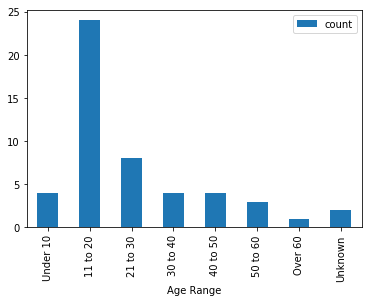

In [216]:
accidentByAgeRange = df2.groupby('Age Range').size().reset_index(name='count')
accidentByAgeRange['count'].sum()
accidentByAgeRange.plot.bar(x='Age Range')

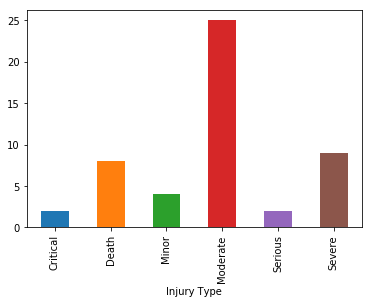

In [231]:
#accidentByInjury = df2_eng.groupby('Injury Type').size().reset_index(name='count')
accidentByInjury = df2_eng.groupby('Injury Type').size()
accidentByInjury.plot.bar(x='Injury Type')

In [198]:
accidentByInjuryAge = df2_eng.groupby(['Injury Type', 'Age Range']).size().reset_index(name='count')
accidentByInjuryAge

,Injury Type,Age Range,count
0,Critical,21 to 30,1
1,Critical,40 to 50,1
2,Death,Under 10,1
3,Death,11 to 20,3
4,Death,21 to 30,1
5,Death,30 to 40,1
6,Death,40 to 50,1
7,Death,50 to 60,1
8,Minor,Under 10,1
9,Minor,11 to 20,1


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B5443ED940>],
      dtype=object)

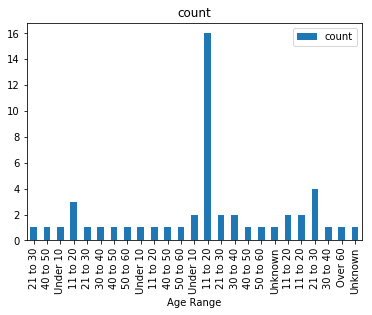

In [225]:
accidentByInjuryAge.plot.bar(x='Age Range', by='Injury Type', subplots="true")

In [87]:
#accidentByAge = accidentByAge.set_index('Age')
x = accidentByAge['Age']

In [199]:
df2ByAgeInjury = df2_eng.groupby(['Injury Type','Age Range']).size().reset_index(name='count')
df2ByAgeInjury.head()

,Injury Type,Age Range,count
0,Critical,21 to 30,1
1,Critical,40 to 50,1
2,Death,Under 10,1
3,Death,11 to 20,3
4,Death,21 to 30,1


In [ ]:
df2ByAgeInjury.plot.bar(x='Age Range', y='Age Range')